# Численное решение дифференциальных уравнений



In [1]:
using DifferentialEquations, Plots

## 3. Системы дифференциально-алгебраических уравнений

Системы дифференциально-алгебраических уравнений (или ОДУ с ограничениями) включают дифференциальные и алгебраические уравнения, в общем случае в неявной форме имеют вид: 

$$ f(y,\dot y,x,t) =0$$
$$ g(y,x,t) = 0$$

где ($x$,$y$) - зависимые переменные, для части которых, $x$, отсутствуют производные. Переменные $y$ и $x$ называют соответственно *дифференциальными* и *алгебраическими* 

Важный специальный класс ДАУ это системы, записанные в полуявной форме:

$$ \frac{dy}{dt} = f(y,x,t)$$
$$ 0 = g(y,x,t) $$

Решение ДАУ является более сложной задачей по сравнению с решением ОДУ

Большинство практических задач, связанных с механическими системами, электрическими цепями, кинетикой химических реакций имеют дело именно с системами дифференциально-алгебраических уравнений

### 3.1 Решение ДАУ в форме с матрицей масс

Запись системы дифференциальных уравнений в форме  с матрицей масс имеет вид:
$$M\frac{du}{dt} = f(u,t)$$

где $M$ - *матрица масс*. Для системы обыкновенных дифференциальных уравнений $M=I$. Для ДАУ матрица масс сингулярная, диагональные элементы которой, соответствующие алгебраическим переменным, равны нулю

Рассмотрим и решим систему уравнений Робертсона, записанную в виде системы с двумя дифференциальными и одним алгебраическим уравнением

\begin{equation*}
 \begin{cases}
   \frac{dx}{dt} = -0.04x+10^4yz, 
   \\
   \frac{dy}{dt} = 0.04x - 10^4yz-3 \times 10^7y^2,
   \\
   0 = x+y+z -1
 \end{cases}
\end{equation*}

$$ x(0)=1, y(0)=0, z(0)=0$$

Переменные $x$ и $y$ - дифференциальные, переменная $z$ - алгебраическая. Системе соответствует сингулярная матрица масс

$$M=\begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 0 \end{bmatrix}$$

In [2]:
function robertson!(du, u, p, t)  
    x, y, z = u
    k₁, k₂, k₃ = p
    du[1] = -k₁*x + k₂*y*z
    du[2] =  k₁*x - k₂*y*z - k₃*y^2
    du[3] =  x + y + z -1 
    nothing
end    

M = [
    1  0  0
    0  1  0
    0  0  0
];

Прежде чем формировать задачу `ODEProblem`, необходимо подготовить функцию, прикрепив `M` к исходной функции

In [3]:
f = ODEFunction(robertson!, mass_matrix = M);

Далее процедура решения ничем не отличается от ранее рассмотренной. Необходимо учесть, что не все численные алгоритмы работают с системами уравнений с сингулярной матрицей масс. Список совместимых см. [здесь](https://diffeq.sciml.ai/stable/solvers/dae_solve/#dae_solve_full)

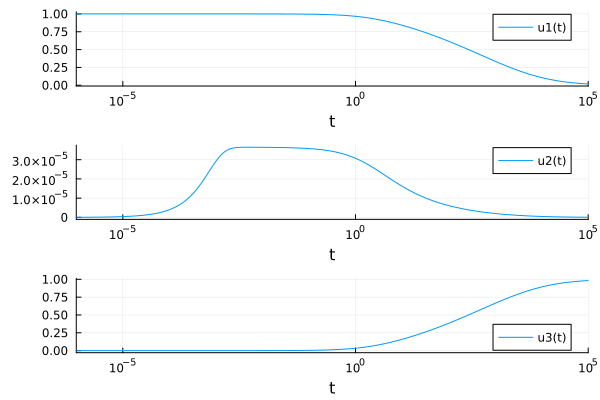

In [4]:
u0     = [1.0, 0.0, 0.0]  # начальные значения переменных
tspan  = (0.0, 1e5)       # интервал времени расчета
params = [0.04, 1e4, 3e7] # параметры модели

prob = ODEProblem(f, u0, tspan, params)

sol  = solve(prob, Rodas5(), reltol=1e-8, abstol=1e-8)

plot(sol, xscale=:log10, tspan=(1e-6, 1e5), layout=(3,1))

### 3.2 Решение ДАУ в неявной форме записи

Если задача не может быть представлена в полуявной форме с матрицей масс, решение осуществляется неявными алгоритмами численного решения систем ДАУ, записанных в виде функции невязок.

Перепишем и решим систему уравнений Робертсона в неявном виде: 

\begin{equation*}
 \begin{cases}
   0 = -0.04x+10^4yz - \frac{dx}{dt}, 
   \\
   0 = 0.04x - 10^4yz-3 \times 10^7y^2 - \frac{dy}{dt},
   \\
   0 = x+y+z -1
 \end{cases}
\end{equation*}

$$ x(0)=1, y(0)=0, z(0)=0$$


In [5]:
# Функция невязок уравнений
function robertson_dae!(res,du,u,p,t)
    x, y, z = u
    k₁, k₂, k₃ = p    
    res[1] = -k₁*x + k₂*y*z - du[1]
    res[2] =  k₁*x - k₂*y*z - k₃*y^2 - du[2]
    res[3] =  x + y + z -1 
    nothing    
end

robertson_dae! (generic function with 1 method)

Решаемая задача определяется как `DAEProblem`, для которой дополнительно требуется указать начальные значения производных du (получаются из системы уравнений после подстановки в нее u0)

In [6]:
u0     = [1.0, 0.0, 0.0]      
du0    = [-0.04, 0.04, 0.0]
tspan  = (1e-6, 1e5)        
params = [0.04, 1e4, 3e7] 

prob = DAEProblem(robertson_dae!, du0, u0, tspan, params)

DAEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (1.0e-6, 100000.0)
u0: 3-element Vector{Float64}:
 1.0
 0.0
 0.0
du0: 3-element Vector{Float64}:
 -0.04
  0.04
  0.0

Список доступных решателей для задач класса `DAEProblem` см. [здесь](https://diffeq.sciml.ai/stable/solvers/dae_solve/). Применим DABDF2() 

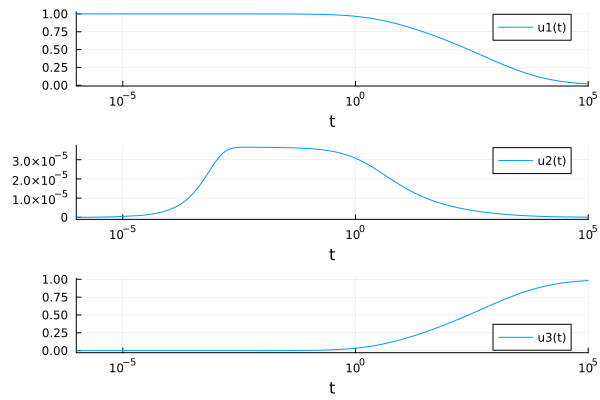

In [7]:
sol = solve(prob, DABDF2(), reltol = 1e-8, abstol = 1e-8, dt=1e-6)

plot(sol, xscale = :log10, tspan = (1e-6, 1e5), layout = (3,1))

Некоторые решатели для определения начальных условий требуют явного указания массива дифференциальных переменных задачи с помощью дополнительного аргумента `differential_vars` при определении `DAEProblem` 

In [8]:
prob = DAEProblem(robertson_dae!, du0, u0, tspan, params, differential_vars=[true, true, false]);

### 3.3 Сравнение двух способов по быстродействию

Рассмотрим большую разреженную систему дифференциально-алгебраических уравнений $f(u,\dot u,t)=0$ вида:

$$\frac{du}{dt}=-A_{2n} u - b$$

$A_{2n}$ - разреженная матрица $2n \times 2n$

$b$ - заданный вектор

$u$ - вектор переменных такой, что первые $n$ переменных дифференциальные, а следующие $n$ переменных алгебраические

Таким образом система состоит из $n$ дифференциальных уравнений и $n$ алгебраических уравнений

Эта же система в полуявной форме с матрицей масс:

$$M\frac{du}{dt}=-A_{2n} u - b$$

$$M=\begin{bmatrix} I_n & 0 \\ 0 & 0_n \end{bmatrix}$$

и в неявной форме:

$$0 =-A_{2n} u - b - \frac{du}{dt}$$


In [16]:
using LinearAlgebra, SparseArrays

n = 1000

# Сгенерируем случайную матрицу A и вектор b
B = sprandn(4n, 2n, 0.0005)
A = B' * B + I*0.1
b = -A * ones(2n)

tspan = (0,20)     # Интервал расчета
p = (A, b, n)  # Параметры
u0 = zeros(2n) # Начальные значения переменных;

Сформируем задачу для решения в форме с матрицей масс. 

In [19]:
function mat_mass!(du, u, p, t)
    A, b = p
    du .= - A * u .- b
    nothing
end

M         = diagm(0 => [ones(n); zeros(n)])
f_mass    = ODEFunction(mat_mass!, mass_matrix = M)
prob_mass = ODEProblem(f_mass, u0, tspan, p);

Задача для решения в неявной форме

In [20]:
function mat_dae!(res, du, u, p, t)
    A, b, n = p
    du[n+1:end] .= 0.0
    res[:] = - A*u .- b .- du
    nothing
end

du0 = [-b[1:n]; zeros(n)]; # начальные значения производных
differential_vars = [fill(true, n); fill(false,n)]
prob_dae = DAEProblem(mat_dae!, du0, u0, tspan, p, differential_vars = differential_vars);

Первую задачу решим с использованием QNDF(), вторую - с использованием IDA() C-библиотеки [Sundials.jl](https://github.com/SciML/Sundials.jl), который рекомендуется как наиболее эффективный для решения больших систем

In [22]:
using Sundials

@time sol_mass = solve(prob_mass, QNDF(), save_idxs = [1, 550, 1300, 1150])
@time sol_dae  = solve(prob_dae,  IDA(),  save_idxs = [1, 550, 1300, 1150]);

  2.414008 seconds (11.39 k allocations: 516.063 MiB, 0.29% gc time)
  3.520884 seconds (541.72 k allocations: 7.292 GiB, 2.48% gc time)


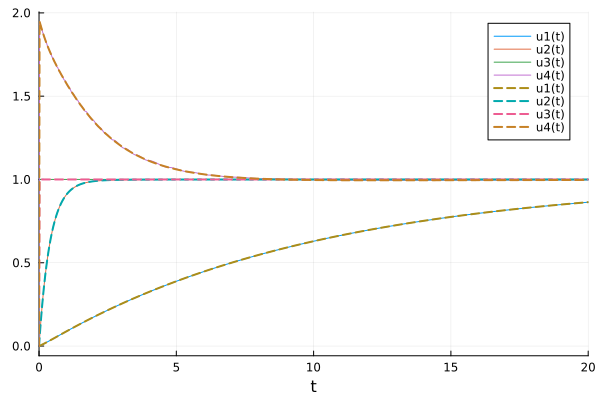

In [23]:
plot(sol_mass)
plot!(sol_dae, ls = :dash, lw = 2)

In [24]:
sol_mass.stats

DiffEqBase.Stats
Number of function 1 evaluations:                  154
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    17
Number of linear solves:                           100
Number of Jacobians created:                       1
Number of nonlinear solver iterations:             100
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          50
Number of rejected steps:                          0

In [25]:
sol_dae.stats

DiffEqBase.Stats
Number of function 1 evaluations:                  102
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    27
Number of linear solves:                           0
Number of Jacobians created:                       27
Number of nonlinear solver iterations:             100
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          72
Number of rejected steps:                          3

### 3.4 Ускорение вычислений

Ускорить вычисления можно, если (а) учесть разреженность решаемой системы и (б) подготовив функцию аналитического расчета матрицы Якоби. В данном примере система уравнений линейная, и матрица производных имеет простой вид:

 - для системы с матрицей масс
 
 $J = \frac{df}{du}  = -A$
 
 - для системы в неявном виде
 
 $J = \frac{df}{du} + \gamma \frac{df}{ d \dot u} = -A - \gamma M$

где $\gamma$ - параметр, задаваемый решателем


In [26]:
# Функция вычисления матрицы Якоби для решения системы в форме с матрицей масс
function mass_jac!(J,u,p,t)
    A, ~, ~ = p
    J.nzval .= -nonzeros(A)
    return nothing
end

# Функция вычисления матрицы Якоби для решения системы, заданной в неявной форме
function dae_jac!(J,du,u,p,gamma,t)
    A, ~, n = p
    J.nzval .= -nonzeros(A) 
    J[1:2n+1:2n^2] .-= gamma
    return nothing
end

dae_jac! (generic function with 1 method)

Присоединим функции вычисления матрицы Якоби к исходным функциям, передав также с помощью аргумента `jac_prototype` образ разреженной матрицы Якоби, и сформируем задачи

In [27]:
f_mass_jac = ODEFunction(mat_mass!, jac = mass_jac!, jac_prototype = A, mass_matrix = sparse(M))
f_dae_jac  = DAEFunction(mat_dae!,  jac = dae_jac!,  jac_prototype = A)

prob_mass_jac = ODEProblem(f_mass_jac,     u0, tspan, p);
prob_dae_jac  = DAEProblem(f_dae_jac, du0, u0, tspan, p, differential_vars = differential_vars);

Для IDA() обязательно указать решатель разреженных систем линейных алгебраических уравнений KLU

In [35]:
@time sol_mass_jac = solve(prob_mass_jac, QNDF(),                    save_idxs = [1, 550, 1300, 1150]);
@time sol_dae_jac  = solve(prob_dae_jac,  IDA(linear_solver = :KLU), save_idxs = [1, 550, 1300, 1150]);

  0.354835 seconds (15.70 k allocations: 345.084 MiB, 5.76% gc time)
  0.035207 seconds (2.18 k allocations: 19.138 MiB)


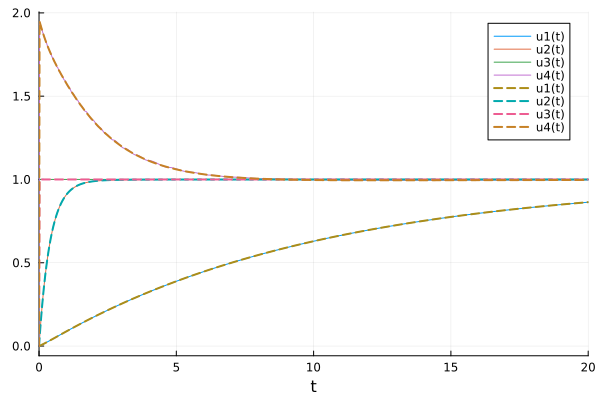

In [36]:
plot(sol_mass_jac)
plot!(sol_dae_jac, ls=:dash, lw = 2)

### 3.5 Примеры 
### Математический маятник
Рассмотрим механическую систему, описывающую колебательный процесс математического маятника в декартовых координатах:

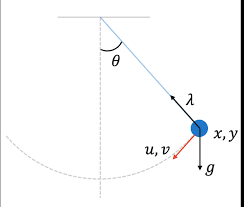


\begin{equation*}
 \begin{cases}
   \frac{dx}{dt} = u, 
   \\
   \frac{dy}{dt} = v,
   \\
   \frac{du}{dt} = - \lambda x 
   \\
   \frac{dv}{dt} = - \lambda y - g 
   \\
   0 = x^2 + y^2 -l^2
 \end{cases}
\end{equation*}

где $(x,y)$ - координаты положения маятника, $(u, v)$ - соответствующие скорости, $\lambda$ - коэффициент натяжения нити, $l$ - длина маятника, $g$ - ускорение свободного падения.

Численное решение этих дифференциально-алгебраических уравнений затруднено по причине высокого индекса системы. *Индекс ДАУ* - наименьшее число дифференцирований, которое нужно произвести, чтобы система не имела сингулярных матриц, и является мерой близости системы к соответствующей ей системе ОДУ (ОДУ имеет индекс 0). Данная система имеет индекс 3. Продифференцируем последовательно последнее уравнение по $t$, чтобы уменьшить индекс системы:

Индекс 3: $0 = x^2 + y^2 − 1$ 

Индекс 2: $0 = 2x\dot x + 2y\dot y → 0 = xu + yv$

Индекс 1: $0 = u^2 + v^2 − λ(x^2 + y^2) − gy$

Индекс 0: $\dot λ = −3gv$

Для численного решения достаточно, чтобы система имела индекс 1. Таким образом, необходимо заменить последнее уравнение системы на $0 = u^2 + v^2 − λ(x^2 + y^2) − gy$. Если заменить на $\dot λ = −3gv$, система становится системой обыкновенных дифференциальных уравнений.

Протестируем решение задачи с разными формулировками (системами разных индексов), различающимися последним уравнением. Полагаем, что $l=1$, начальные координаты маятника $x(0)=1$, $y(0)=0$, начальная скорость $u(0)=v(0)=0$ и коэффициент натяжения $\lambda(0)=0$. Правильное задание начальных значений важно для систем индекса 2, 1 или 0, поскольку уравнение связи $0 = x^2 + y^2 -l^2$ в явном виде в них не присутствует и может нарушаться

In [37]:
function pendulum!(du, u, p, t)
    pos_x, pos_y, vel_x, vel_y, λ = u
    du[1] = vel_x
    du[2] = vel_y
    du[3] = - λ * pos_x
    du[4] = - λ * pos_y - 9.8
#    du[5] = pos_x^2 + pos_y^2 - 1
#    du[5] = pos_x*vel_x + pos_y*vel_y
    du[5] = vel_x^2 + vel_y^2 - λ * (pos_x^2 + pos_y^2) - pos_y * 9.8
#    du[5] = - 3 * 9.8 * vel_y
    nothing
end

u0    = [1, 0, 0, 0, 0]
tspan = (0, 5)

M         = diagm(0 => [1,1,1,1,0])  # при решении ОДУ установить все 1
f_mass    = ODEFunction(pendulum!, mass_matrix = M)
prob_mass = ODEProblem(f_mass, u0, tspan);

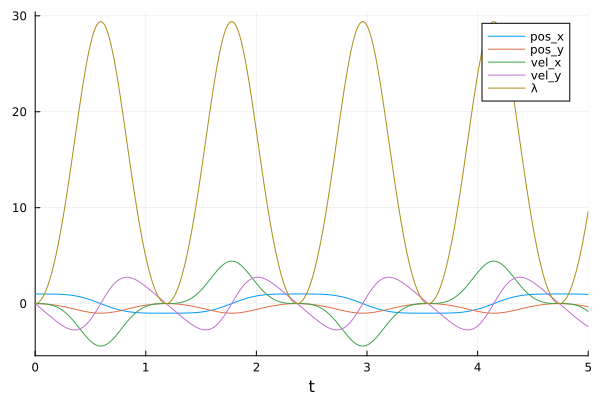

In [38]:
sol = solve(prob_mass, Rodas5(), saveat=0.01)
plot(sol, label = ["pos_x" "pos_y" "vel_x" "vel_y" "λ"])

Траектория, описываемая маятником в пространстве 

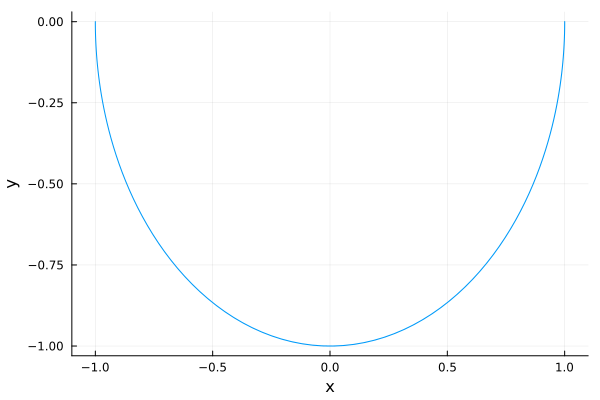

In [39]:
plot(sol, idxs=[(1, 2)], label = "", xlabel = "x", ylabel = "y")

Результаты тестирования

| Индекс  |  Число шагов  | Время расчета, мс
|--------|---------------|--------------
| 3      |   NA          |  NA 
| 2      |   2064        |  5.2
| 1      |   92          |  0.3
| 0      |   50          |  0.2

Функция автоматического преобразования системы дифференциально-алгебраических уравнений с использованием алгоритма Пантелидеса, понижающего индекс, реализована в пакете [ModelingToolkit.jl](https://mtk.sciml.ai/stable/mtkitize_tutorials/modelingtoolkitize_index_reduction/)  

### Электрическая цепь

Рассмотрим электрическую цепь с источником постоянного напряжения $E$.

![Image](http://ets.ifmo.ru/osipov/os1/3_2.files/image031.jpg)

Составим систему уравнений цепи по законам Кирхгофа:

\begin{equation*}
 \begin{cases}
   -i_i + i_2 +i_L = 0 
   \\
   r_1 i_1 + r_2 i_2 =E
   \\
   u_L=L\frac{di_L}{dt}=r_2 i_2
 \end{cases}
\end{equation*}

Система состоит из одного дифференциального и двух алгебраических уравнений. Перепишем в форме с матрицей масс:

\begin{equation*}
 \begin{cases}
   0 = i_i - i_2 - i_L
   \\
   0 = E -r_1 i_1 - r_2 i_2
   \\
   L\frac{di_L}{dt}=r_2 i_2
 \end{cases}
\end{equation*}


Пусть $r_1=r_2=0.2$, $L=0.1$, $E=10$.  Решение системы для $i_i(0)=i_2(0)=i_L(0)=0$ дает изменение токов в цепи при включении источника напряжения. 

In [41]:
using LinearAlgebra

function RL_mass!(du, u, p, t)
    E,  r1, r2 = p
    i1, i2, iL = u
    du[1] = i1 - i2 - iL
    du[2] = E - r1 * i1 - r2 * i2
    du[3] = r2 * i2
    nothing
end

r1 = r2 = 0.2
L  = 0.1
E  = 10

u0    = zeros(3)
tspan = (0, 10)
p     = (E, r1, r2)

M         = diagm(0 => [0, 0, L])
f_mass    = ODEFunction(RL_mass!, mass_matrix = M)
prob_mass = ODEProblem(f_mass, u0, tspan, p);

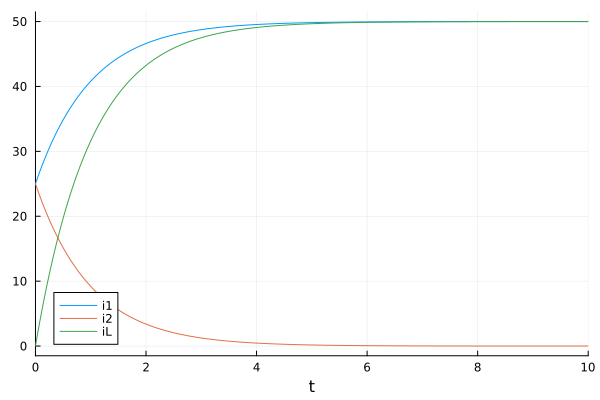

In [42]:
sol = solve(prob_mass, Rodas5())
plot(sol, label = ["i1" "i2" "iL"])

In [43]:
 # Самостоятельно: решить любой из примеров вторым способом (как неявную систему ДАУ)